# Pandas

* memory usage of Parquet read in Pandas as Arrow or NumPy arrays
  * 2021+ 11GB 6s as Arrow
  * 2021+ 39GB 16s at NumPy

In [1]:
import pandas as pd
import polars as pl
from humanfriendly import format_size, format_number
from simpler_mpl import set_commas, set_common_mpl_styles
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

display(f"Pandas {pd.__version__}, Polars {pl.__version__}")

from cell_profiler import cell_profiler as cp
%start_cell_profiler

def show_rows_memory(df, deep=False):
    """
    Show rows and memory cost of a Pandas/Polars dataframe
    `deep=True` only has an impact on Pandas numpy-backed string columns, which otherwise are undercounted
    """
    num_bytes = 0
    df_type = 'Unknown'
    try:
        num_bytes = df.estimated_size() # try Polars
        df_type = 'Polars'
    except AttributeError:
        pass
    try:
        num_bytes = df.memory_usage(deep=deep, index=False).sum() # try Pandas
        df_type = 'Pandas'
    except AttributeError:
        pass
    display(f"{df_type} df with {format_number(df.shape[0])} rows, {format_size(num_bytes)} bytes")

'Pandas 2.0.1, Polars 0.17.10'

In [1] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 208.3 MiB


In [2]:
%stop_cell_profiler

'Profiling disabled'

In [3]:
dfpda = pd.read_parquet('../test_result_2021on.parquet', dtype_backend="pyarrow")

In [4]:
show_rows_memory(dfpda)

'Pandas df with 82,012,245 rows, 11.19 GB bytes'

In [5]:
dfpda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82012245 entries, 0 to 82012244
Data columns (total 14 columns):
 #   Column             Dtype                 
---  ------             -----                 
 0   test_id            int64[pyarrow]        
 1   vehicle_id         int64[pyarrow]        
 2   test_date          timestamp[ns][pyarrow]
 3   test_class_id      int64[pyarrow]        
 4   test_type          large_string[pyarrow] 
 5   test_result        large_string[pyarrow] 
 6   test_mileage       int64[pyarrow]        
 7   postcode_area      large_string[pyarrow] 
 8   make               large_string[pyarrow] 
 9   model              large_string[pyarrow] 
 10  colour             large_string[pyarrow] 
 11  fuel_type          large_string[pyarrow] 
 12  cylinder_capacity  int64[pyarrow]        
 13  first_use_date     timestamp[ns][pyarrow]
dtypes: int64[pyarrow](5), large_string[pyarrow](7), timestamp[ns][pyarrow](2)
memory usage: 10.4 GB


In [6]:
dfpdn = pd.read_parquet('../test_result_2021on.parquet', dtype_backend="numpy_nullable")

In [7]:
show_rows_memory(dfpdn, deep=True)

'Pandas df with 82,012,245 rows, 39.66 GB bytes'

In [8]:
dfpdn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82012245 entries, 0 to 82012244
Data columns (total 14 columns):
 #   Column             Dtype         
---  ------             -----         
 0   test_id            Int64         
 1   vehicle_id         Int64         
 2   test_date          datetime64[ns]
 3   test_class_id      Int64         
 4   test_type          object        
 5   test_result        object        
 6   test_mileage       Int64         
 7   postcode_area      object        
 8   make               object        
 9   model              object        
 10  colour             object        
 11  fuel_type          object        
 12  cylinder_capacity  Int64         
 13  first_use_date     datetime64[ns]
dtypes: Int64(5), datetime64[ns](2), object(7)
memory usage: 8.9+ GB


# Speed test

In [9]:
%timeit dfpda['make'].str.len() # e.g. TOYOTA, VOLKSWAGEN

1.26 s ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit dfpdn['make'].str.len()

9.31 s ± 275 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit dfpda['test_class_id'].max()

103 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit dfpdn['test_class_id'].max()

201 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
import numpy as np
np.testing.assert_approx_equal(74115.13152002622, dfpda['test_mileage'].mean())
np.testing.assert_approx_equal(74115.13152002622, dfpdn['test_mileage'].mean())

In [14]:
%timeit dfpda['test_mileage'].mean()

73.4 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%timeit dfpdn['test_mileage'].mean()

183 ms ± 9.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
# IAN IS IT SANE TO TEST THE TIME OF 2 OPS - I REALLY NEED TO SEPARATE THESE...
#%timeit dfpda['test_mileage'].dropna().mean()

In [17]:
#%timeit dfpdn['test_mileage'].dropna().mean()

# Mileage vs first use year

### Subsample using NumPy and Arrow

**TODO**

In [18]:
%start_cell_profiler

'Profiling enabled'

In [18] used 25155.5 MiB RAM in 204.12s (system mean cpu 24%, single max cpu 100%), peaked 12233.4 MiB above final usage, current RAM usage now 25363.8 MiB


In [19]:
#df_fuel = dfpda[:10000].query('test_result=="P"')
#df_fuel = dfpda.query('test_result=="P"').sample(10_000)

In [19] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 18%), peaked 0.0 MiB above final usage, current RAM usage now 25363.8 MiB


In [20]:
%time dfpda.query('test_result=="P"');

CPU times: user 8.6 s, sys: 5.49 s, total: 14.1 s
Wall time: 13.9 s
In [20] used 628.2 MiB RAM in 14.28s (system mean cpu 7%, single max cpu 100%), peaked 9639.3 MiB above final usage, current RAM usage now 25992.1 MiB


In [21]:
df_fuel = dfpda.query('test_result=="P"').sample(10_000). \
            assign(first_use_year=lambda dfx: dfx['first_use_date'].dt.year) \
            [['test_mileage', 'fuel_type', 'first_use_year']]. \
            dropna(). \
            query("fuel_type in ['PE', 'DI']")

In [21] used 1.8 MiB RAM in 15.88s (system mean cpu 9%, single max cpu 100%), peaked 9544.8 MiB above final usage, current RAM usage now 25993.8 MiB


In [22]:
#def add_year(dfx):
#    dfx['first_use_year'] = dfx['first_use_date'].dt.year
#    return dfx
#df_fuel = df_fuel.pipe(add_year)[['test_mileage', 'fuel_type', 'first_use_year']]. \


In [22] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 25%), peaked 0.0 MiB above final usage, current RAM usage now 25993.8 MiB


In [23]:
#dfs_allfuel = dfpda.query('test_result=="P"').sample(10_000) 
#dfs_allfuel['first_use_year'] = dfs_allfuel['first_use_date'].dt.year
#dfs_allfuel = dfs_allfuel[['test_mileage', 'fuel_type', 'first_use_year']]
#dfs_allfuel = dfs_allfuel.dropna() # some of the test_mileage rows are empty
#df_fuel = dfs_allfuel[dfs_allfuel['fuel_type'].isin(['PE', 'DI'])]

In [23] used 0.0 MiB RAM in 0.10s (system mean cpu 12%, single max cpu 33%), peaked 0.0 MiB above final usage, current RAM usage now 25993.8 MiB


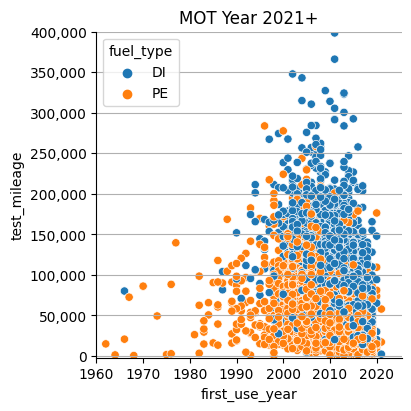

In [24] used 3.4 MiB RAM in 0.77s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 25997.2 MiB


In [24]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
# Note this is Pandas Arrow with Seaborn
# TODO maybe different symbols
# h/t https://stackoverflow.com/questions/56394204/pandas-groupby-scatter-plot-in-a-single-plot for categorical solution
#sns.scatterplot(x=dfs['first_use_year'], y=dfs['test_mileage'], c=pd.Categorical(dfs['fuel_type']).codes, ax=ax)
sns.scatterplot(x=df_fuel['first_use_year'], y=df_fuel['test_mileage'], hue=df_fuel['fuel_type'], hue_order=['DI', 'PE'], ax=ax)
#ax.scatter(x=dfs['first_use_year'], y=dfs['test_mileage'], c=pd.Categorical(dfs['fuel_type']).codes,)
ax.set_xlim(xmin=1960)
ax.set_ylim(ymax=400000)
set_commas(ax, y_axis=True)
set_common_mpl_styles(ax, ymin=-2000, title="MOT Year 2021+")

In [25]:
#dfs.info()

In [25] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 18%), peaked 0.0 MiB above final usage, current RAM usage now 25997.3 MiB


# Old experiments to load in single file dumps

In [26]:
#dfpda2018 = pd.read_parquet('../test_result_2018on.parquet', dtype_backend="pyarrow")

In [26] used 0.0 MiB RAM in 0.10s (system mean cpu 14%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 25997.3 MiB


In [27]:
#dfpda2018.memory_usage(deep=True, index=False) # deep=True gives same answer as deep=False on Arrow

In [27] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25997.3 MiB


In [28]:
#show_rows_memory(dfpda2018) # 198M rows, 27GB

In [28] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25997.3 MiB


In [29]:
#dfpda2021 = pd.read_parquet('../test_result_2021on.parquet', dtype_backend="pyarrow")

In [29] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25997.3 MiB


In [30]:
#show_rows_memory(dfpda2021) # 82M rows 11GB

In [30] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25997.3 MiB


In [31]:
#dfpdn2021 = pd.read_parquet('../test_result_2021on.parquet', dtype_backend="numpy_nullable")

In [31] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25997.3 MiB


In [32]:
#show_rows_memory(dfpdn2021)

In [32] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25997.3 MiB


In [33]:
#show_rows_memory(dfpdn2021, deep=True) # 82M rows 39GB

In [33] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25997.3 MiB
